In [1]:
import json
import numpy as np
import pandas as pd
import geopandas as gpd
from pathlib import Path
import matplotlib.pyplot as plt

In [2]:
import difflib
import Levenshtein

def find_most_similar(target, strings):
    # Initialize the best match and minimum distance
    best_match = None
    min_distance = float('inf')

    # Calculate Levenshtein distance for each string in the list
    for string in strings:
        distance = Levenshtein.distance(target, string)
        if distance < min_distance:
            min_distance = distance
            best_match = string

    return best_match


In [3]:
l = 'nodal'

In [4]:
if l == 'nodal':
    fn = 'regions_onshore_s.geojson'
elif l == 'eso':
    fn = 'eso_zones.geojson'

path = Path.cwd().parent / 'data'
shapes = gpd.read_file(path / fn).set_index('name')

In [102]:
zonal_shapes = gpd.read_file(path / 'eso_zones.geojson').set_index('name').to_crs(epsg=27700)

In [5]:
with open(Path.cwd().parent / 'live' / 'total.json', 'r') as f:
    total = json.load(f)
total = total[list(total)[0]][l]['geographies']
total = pd.DataFrame({key: item['variables'] for key, item in total.items()}).T
total = pd.concat((shapes, total), axis=1)

In [6]:
# const = gpd.read_file(Path.cwd().parent / 'data' / 'constituencies_2021.geojson')
old_shapes = gpd.read_file(Path.cwd().parent / 'data' / 'constituencies_2021.geojson').set_index('PCON21CD')

In [7]:
new_shapes = gpd.read_file(
    Path.cwd().parent /
    'data' /
    'Pre-Operative-Westminster-Boundaries-Shape-v.2' /
    'westminster_const_region.shp'
    ).set_index('NAME')

In [8]:
consumption = pd.read_excel(
    Path.cwd().parent /
    'data' /
    'Subnational_electricity_consumption_statistics_2005-2022.xlsx',
    sheet_name='2022', header=4, index_col=0)
consumption

,Country or region,Local authority,Number of meters\n(thousands):\nDomestic Standard,Number of meters\n(thousands):\nDomestic E7,Number of meters\n(thousands):\nAll Domestic,Number of meters\n(thousands):\nAll Non-Domestic,Number of meters\n(thousands):\nAll meters,Total consumption\n(GWh):\nDomestic Standard,Total consumption\n(GWh):\nDomestic E7,Total consumption\n(GWh):\nAll Domestic,...,Mean consumption\n(kWh per meter):\nDomestic E7,Mean consumption\n(kWh per meter):\nAll Domestic,Mean consumption\n(kWh per meter):\nAll Non-Domestic,Mean consumption\n(kWh per meter):\nAll meters,Median consumption\n(kWh per meter):\nDomestic Standard,Median consumption\n(kWh per meter):\nDomestic E7,Median consumption\n(kWh per meter):\nAll Domestic,Median consumption\n(kWh per meter):\nAll Non-Domestic,Median consumption\n(kWh per meter):\nAll meters,Mean domestic\nconsumption\n(kWh per household)
Code,,,,,,,,,,,,,,,,,,,,,
K03000001,Great Britain (inc unallocated),All local authorities,25512.860,3565.910,29078.770,2458.879,31537.649,77560.978144,16639.387850,94200.365994,...,4666.238870,3239.489359,63370.492562,7927.691103,2398.500000,3362.2,2474.800001,6873.6,2546.199998,3386.628034
K04000001,England and Wales (inc unallocated),All local authorities,23034.833,3248.785,26283.618,2239.837,28523.455,70477.061957,15119.472533,85596.534490,...,4653.885232,3256.649617,63568.877737,7992.736465,2412.199999,3352.0,2489.400001,6787.3,2560.500000,3387.870272
E92000001,England,All local authorities,21659.969,3163.099,24823.068,2092.936,26916.004,66501.632570,14661.838882,81163.471452,...,4635.276633,3269.679294,62462.606596,7872.405928,2416.300001,3339.3,2495.300001,6851.2,2566.199999,3400.442904
E12000001,North East,All local authorities,1198.163,53.857,1252.020,83.812,1335.832,3197.653511,252.564015,3450.217526,...,4689.529962,2755.720776,77908.753549,7470.928963,2206.200000,3376.1,2228.300000,7346.7,2284.000000,2906.053244
E12000002,North West,All local authorities,3130.092,199.757,3329.849,241.669,3571.518,9259.546784,1001.919892,10261.466675,...,5015.693526,3081.661263,70688.480089,7656.318957,2414.800000,3798.1,2458.300000,7811.7,2529.700000,3209.755598
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
S12000045,Scotland,East Dunbartonshire,45.835,2.916,48.751,2.425,51.176,139.965667,12.688840,152.654507,...,4351.454038,3131.310277,58820.303513,5770.160687,2546.800000,3232.2,2571.500000,7612.3,2614.100000,3238.940556
S12000047,Scotland,Fife,172.643,12.259,184.902,12.442,197.344,476.028197,53.677744,529.705941,...,4378.639674,2864.792922,65341.864020,6803.801550,2274.400000,2893.1,2294.700000,7444.3,2352.600000,3074.555486
S12000048,Scotland,Perth and Kinross,69.459,11.613,81.072,8.397,89.469,229.727074,70.210153,299.937227,...,6045.823907,3699.640163,48820.835277,7934.432944,2495.500000,4809.3,2640.500000,7493.9,2745.000000,4218.348414


In [14]:
consumption[[
    'Total consumption\n(GWh):\nAll Domestic',
    'Total consumption\n(GWh):\nAll Non-Domestic',
    'Total consumption\n(GWh):\nAll meters',
]].sum()

Total consumption\n(GWh):\nAll Domestic        4.610566e+05
Total consumption\n(GWh):\nAll Non-Domestic    7.636921e+05
Total consumption\n(GWh):\nAll meters          1.224749e+06
dtype: float64

In [15]:
const_metrics = pd.read_csv(
    Path.cwd().parent / 'data' / 'Westminster_Parliamentary_Constituencies_Dec_2021.csv'
    ).set_index('PCON21CD')

In [16]:
const_people = pd.read_csv(
    Path.cwd().parent / 'data' / 'constituency_data.csv',
    # on_bad_lines='warn',
    sep='delimiter', header=5,
    ).iloc[:-10]

print(const_people.columns)
const_people.columns = ['cols']
# const_people['cols'].str.split(',').apply(lambda x: len(x)).value_counts()
# const_people['cols'].str.split(',').apply(lambda x: x[1])
const_people.loc[:, ['popdens']] = const_people['cols'].str.split(',').apply(lambda x: x[1].replace('"', ''))

const_people.loc[:, ['name']] = const_people['cols'].str.split(',').apply(lambda x: x[2].replace('"', ''))

const_people.loc[:, ['code']] = const_people['cols'].str.split(',').apply(lambda x: x[3].replace('"', ''))

const_people.drop(columns='cols', inplace=True)
const_people = const_people.loc[const_people['name'].str.contains('pca10')]

const_people.loc[:, ['name']] = const_people['name'].str[6:]

const_people

C:\Users\lukas\AppData\Local\Temp\ipykernel_31068\421955498.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  const_people = pd.read_csv(


Index(['"row","2021","Area","mnemonic"'], dtype='object')


,popdens,name,code
10,31.7,Berwick-upon-Tweed,E14000554
11,97.9,Bishop Auckland,E14000569
12,798.0,Blaydon,E14000574
13,1212.1,Blyth Valley,E14000575
14,532.2,City of Durham,E14000641
...,...,...,...
1151,47.6,Thirsk and Malton,E14000993
1152,1295.5,Wakefield,E14001009
1153,1114.3,Wentworth and Dearne,E14001028
1154,4458.6,York Central,E14001061


In [17]:
print(pd.Index(const_people['code']).intersection(old_shapes.index))
pd.Index(const_people['name']).intersection(pd.Index(old_shapes['PCON21NM']))

Index(['E14000554', 'E14000569', 'E14000574', 'E14000575', 'E14000641',
       'E14000658', 'E14000677', 'E14000709', 'E14000733', 'E14000746',
       ...
       'W07000071', 'W07000072', 'W07000073', 'W07000074', 'W07000075',
       'W07000076', 'W07000077', 'W07000078', 'W07000079', 'W07000080'],
      dtype='object', length=544)


Index(['Berwick-upon-Tweed', 'Bishop Auckland', 'Blaydon', 'Blyth Valley',
       'City of Durham', 'Darlington', 'Easington', 'Gateshead', 'Hartlepool',
       'Hexham',
       ...
       'Merthyr Tydfil and Rhymney', 'Blaenau Gwent', 'Bridgend', 'Ogmore',
       'Pontypridd', 'Caerphilly', 'Islwyn', 'Vale of Glamorgan',
       'Cardiff West', 'Cardiff South and Penarth'],
      dtype='object', length=543)

In [18]:
new_shapes.head()

,AREA_CODE,DESCRIPTIO,FILE_NAME,NUMBER,NUMBER0,POLYGON_ID,UNIT_ID,CODE,HECTARES,AREA,TYPE_CODE,DESCRIPT0,TYPE_COD0,DESCRIPT1,geometry
NAME,,,,,,,,,,,,,,,
Aberafan Maesteg,WMC,Westminster Constituency,ABERAFAN_MAESTEG_CO_CONST,1.0,1.0,49094.0,49094.0,W07000081,24929.7065,759.934,VA,CIVIL VOTING AREA,NaN,NaN,"POLYGON ((279385.399 179048.332, 279377.656 17..."
Aberdeen North,WMC,Westminster Constituency,ABERDEEN_NORTH_BURGH_CONST,3.0,3.0,49095.0,49095.0,S14000060,10357.6997,423.163,VA,CIVIL VOTING AREA,NaN,NaN,"POLYGON ((396447.120 813096.860, 396446.030 81..."
Aberdeen South,WMC,Westminster Constituency,ABERDEEN_SOUTH_BURGH_CONST,620.0,620.0,49096.0,49096.0,S14000061,10201.6124,1578.877,VA,CIVIL VOTING AREA,NaN,NaN,"MULTIPOLYGON (((395721.200 801236.600, 395721...."
Aberdeenshire North and Moray East,WMC,Westminster Constituency,ABERDEENSHIRE_NORTH_AND_MORAY_EAST_CO_CONST,616.0,616.0,49097.0,49097.0,S14000062,134319.9724,1201.536,VA,CIVIL VOTING AREA,NaN,NaN,"MULTIPOLYGON (((411118.003 838420.604, 411107...."
Airdrie and Shotts,WMC,Westminster Constituency,AIRDRIE_AND_SHOTTS_CO_CONST,4.0,4.0,49098.0,49098.0,S14000063,23826.4232,0.000,VA,CIVIL VOTING AREA,NaN,NaN,"POLYGON ((281907.696 673240.396, 281960.201 67..."


In [ ]:
pd.Index(const_people['name']).difference(pd.Index(new_shapes['NAME']))

Index(['Aberavon', 'Aberconwy', 'Arfon', 'Barnsley Central', 'Barnsley East',
       'Batley and Spen', 'Beckenham', 'Berwick-upon-Tweed',
       'Bethnal Green and Bow', 'Birmingham',
       ...
       'Wentworth and Dearne', 'West Bromwich East', 'West Bromwich West',
       'West Ham', 'Westminster North', 'Wirral South',
       'Wolverhampton South West', 'Workington', 'Worsley and Eccles South',
       'Wyre and Preston North'],
      dtype='object', length=193)

In [20]:
old_shapes.head()

,OBJECTID,PCON21NM,BNG_E,BNG_N,LONG,LAT,GlobalID,geometry
PCON21CD,,,,,,,,
E14000530,1,Aldershot,484884,155126,-0.78410,51.28895,343e8dc7-3e36-4ae9-a696-0f4be7db7f88,"POLYGON ((483364.601 160961.805, 483370.702 16..."
E14000531,2,Aldridge-Brownhills,404723,302568,-1.93166,52.62087,5402080a-0523-4a4c-83f3-1d9c8b5e5cc9,"POLYGON ((407331.599 295946.795, 407329.497 29..."
E14000532,3,Altrincham and Sale West,374132,389051,-2.39049,53.39766,ecee48b6-c31b-4998-97df-f02b67089c78,"POLYGON ((379104.096 393143.903, 379102.802 39..."
E14000533,4,Amber Valley,440478,349675,-1.39770,53.04283,d2470af3-d629-4f58-a497-76e429c23279,"POLYGON ((446535.298 345394.601, 446553.701 34..."
E14000534,5,Arundel and South Downs,510686,115542,-0.42635,50.92871,c29c56a9-281a-45de-824f-263deb7ab030,"POLYGON ((492610.101 103220.003, 492614.199 10..."


In [23]:
inter = const_metrics.index.intersection(old_shapes.index)
areas = pd.concat((
    const_metrics[['Shape__Area']].loc[inter],
    old_shapes.loc[inter, 'geometry'].area
), axis=1)

In [25]:
old_names = pd.Index(old_shapes['PCON21NM'])

In [26]:
base = Path.cwd().parent / 'data'
prj_file_path = base / "UK_residential_population_2011_1_km.prj"

In [27]:
import rasterio
import geopandas as gpd
from shapely.geometry import shape
from rasterio.features import shapes

base = Path.cwd().parent / 'data'
asc_file_path = base / "UK_residential_population_2011_1_km.asc"

with rasterio.open(asc_file_path) as src:
    asc_data = src.read(1)
    asc_meta = src.meta

crs = "EPSG:27700"

shapes_and_values = shapes(asc_data, mask=asc_data != asc_meta['nodata'], transform=src.transform)

geometries = []
values = []
for geom, value in shapes_and_values:
    geometries.append(shape(geom))
    values.append(value)

# Create a GeoDataFrame
gdf = gpd.GeoDataFrame({'geometry': geometries, 'value': values}, crs=crs)

# Print the GeoDataFrame
print(gdf.head())


                                            geometry  value
0  POLYGON ((459000.000 1218000.000, 459000.000 1...    7.0
1  POLYGON ((465000.000 1217000.000, 465000.000 1...   21.0
2  POLYGON ((466000.000 1217000.000, 466000.000 1...   15.0
3  POLYGON ((465000.000 1216000.000, 465000.000 1...    1.0
4  POLYGON ((466000.000 1216000.000, 466000.000 1...    9.0


In [28]:
pts = gdf.copy()
pts['geometry'] = pts['geometry'].centroid
pts = pts.loc[pts['value'] > 0]

# assuming electricity use per person: yearly GB demand / population
average_household_demand = 2.7 # (OFGEM)
average_occupancy = 2.2 # (gov.uk)

demand_per_person = average_household_demand / average_occupancy

pts['demand'] = pts['value'] * demand_per_person

In [29]:
pts

,geometry,value,demand
0,POINT (459500.000 1217500.000),7.0,8.590909
1,POINT (465500.000 1216500.000),21.0,25.772727
2,POINT (466500.000 1216500.000),15.0,18.409091
3,POINT (465500.000 1215500.000),1.0,1.227273
4,POINT (466500.000 1215500.000),9.0,11.045455
...,...,...,...
125816,POINT (92500.000 10500.000),35.0,42.954545
125817,POINT (91500.000 9500.000),15.0,18.409091
125818,POINT (87500.000 8500.000),58.0,71.181818
125819,POINT (88500.000 8500.000),20.0,24.545455


In [30]:
hold = pts.sjoin(total[['single_rate_domestic', 'geometry']].to_crs(crs), how='left').dropna()

In [31]:
hold['savings'] = hold['demand'] * hold['single_rate_domestic']
hold['savings'].sort_values()

29711         2.668900
30497         2.668900
28401         2.668900
26764         2.668900
29082         2.668900
             ...      
5401     301355.534453
7902     311873.436289
5464     334443.337327
7948     341728.560875
5430     408488.709593
Name: savings, Length: 116625, dtype: float64

In [32]:
hold = hold.drop(columns=['index_right']).sjoin(new_shapes, how='left')

In [36]:
hold.to_file('demand_and_single_rate_domestic.geojson', driver='GeoJSON')

In [38]:
byconst = hold.groupby('index_right')['savings'].sum()

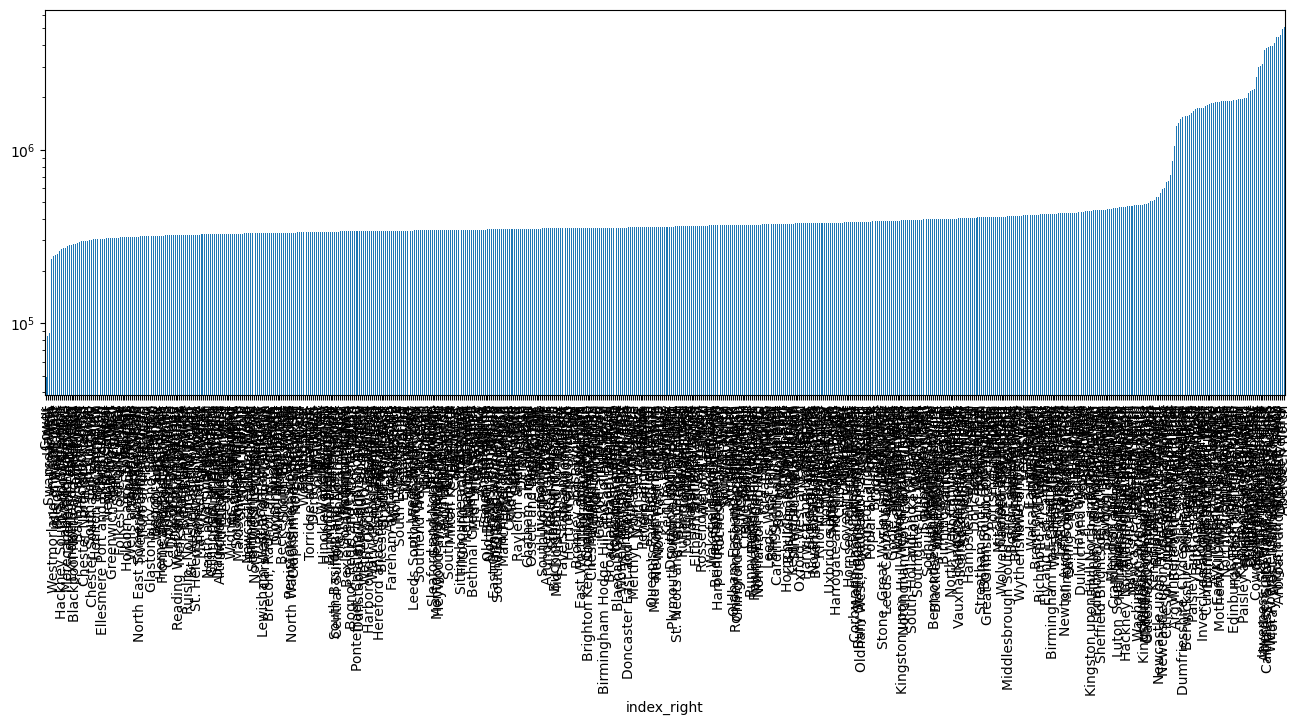

In [50]:
fig, ax = plt.subplots(figsize=(16, 5))
byconst.sort_values().plot.bar(ax=ax)
ax.set_yscale('log')
plt.show()

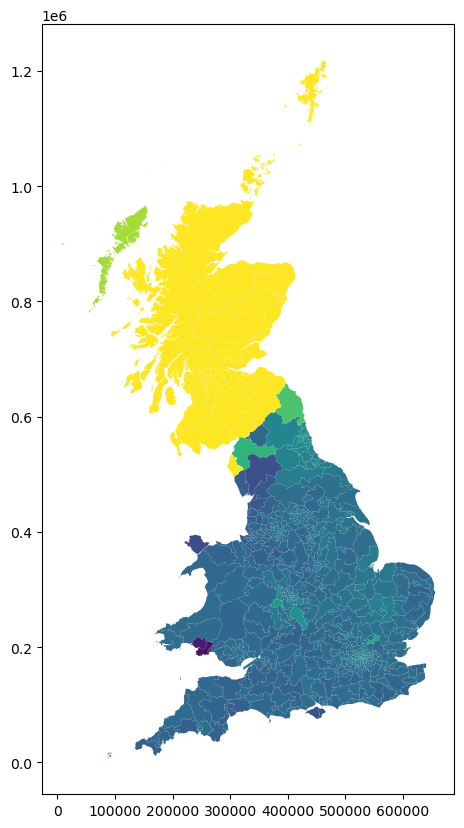

In [53]:
fig, ax = plt.subplots(figsize=(16, 10))
pd.concat((new_shapes, byconst), axis=1).plot(column='savings', vmin=0, vmax=1e6, ax=ax)
plt.show()

In [55]:
new_shapes['CODE'].value_counts()

CODE
W07000081    1
E14001413    1
E14001406    1
E14001407    1
E14001408    1
            ..
E14001231    1
E14001232    1
S14000083    1
E14001233    1
E14001605    1
Name: count, Length: 632, dtype: int64

In [123]:
ns = new_shapes[['geometry', 'CODE']]
ps = pts[['geometry', 'demand']]
ts = total[['geometry', 'single_rate_domestic']]

In [124]:
mapper = (
    ps.sjoin(ts.to_crs('EPSG:27700'), how='left')
    .dropna()
    .rename(columns={'index_right': 'nodal_region'})
    .sjoin(ns, how='left')
    .rename(columns={'index_right': 'constituency'})
)

In [126]:
mapper = pd.concat((
    # gpd.sjoin_nearest(mapper.loc[mapper['constituency'].isna()], ns, how='left').rename(columns={'index_right': 'constituency'})
    gpd.sjoin_nearest(mapper.loc[mapper['constituency'].isna()].drop(columns=['constituency']), ns, how='left').rename(columns={'index_right': 'constituency'}),
    mapper.loc[~mapper['constituency'].isna()]
), axis=0)

mapper = gpd.sjoin_nearest(mapper, zonal_shapes, how='left').rename(columns={'index_right': 'zonal_region'}).sort_values('constituency')

In [127]:
mapper

,geometry,demand,nodal_region,single_rate_domestic,CODE_left,constituency,CODE_right,CODE,zonal_region
95763,POINT (273500.000 194500.000),1552.500000,8515,3.023089,NaN,Aberafan Maesteg,NaN,W07000081,GB0 Z13
99189,POINT (281500.000 181500.000),3181.090909,5193,3.023027,NaN,Aberafan Maesteg,NaN,W07000081,GB0 Z13
99190,POINT (282500.000 181500.000),2746.636364,5193,3.023027,NaN,Aberafan Maesteg,NaN,W07000081,GB0 Z13
99191,POINT (283500.000 181500.000),336.272727,5193,3.023027,NaN,Aberafan Maesteg,NaN,W07000081,GB0 Z13
99192,POINT (284500.000 181500.000),66.272727,5193,3.023027,NaN,Aberafan Maesteg,NaN,W07000081,GB0 Z13
...,...,...,...,...,...,...,...,...,...
37284,POINT (458500.000 444500.000),346.090909,6019,3.148182,NaN,York Outer,NaN,E14001605,GB0 Z8
37285,POINT (459500.000 444500.000),23.318182,6019,3.148182,NaN,York Outer,NaN,E14001605,GB0 Z8
37286,POINT (461500.000 444500.000),7.363636,6020,3.454631,NaN,York Outer,NaN,E14001605,GB0 Z8
36508,POINT (458500.000 450500.000),3278.045455,6019,3.148182,NaN,York Outer,NaN,E14001605,GB0 Z8


In [131]:
final = (
    mapper
    .sort_values('constituency')
    [['demand', 'constituency', 'CODE', 'nodal_region', 'zonal_region']]
    .rename(columns={
        'CODE': 'constituency_code',
        'constituency': 'constituency_name',
        })
)

In [133]:
final.to_csv('constituency_mapper.csv', index=False)

,geometry,demand,model_region,single_rate_domestic,constituency,zonal_region
5620,POINT (395500.000 800500.000),813.681818,8015,35.427637,Aberdeen South,GB0 Z2
1837,POINT (392500.000 867500.000),225.818182,8013,35.427745,Aberdeenshire North and Moray East,GB0 Z2
4308,POINT (408500.000 833500.000),36.818182,6485,35.427692,Aberdeenshire North and Moray East,GB0 Z2
4212,POINT (409500.000 835500.000),65.045455,6485,35.427692,Aberdeenshire North and Moray East,GB0 Z2
3971,POINT (412500.000 840500.000),4.909091,6485,35.427692,Aberdeenshire North and Moray East,GB0 Z2
...,...,...,...,...,...,...
125426,POINT (181500.000 32500.000),1966.090909,5207,3.023434,Truro and Falmouth,GB0 Z17
5835,POINT (392500.000 794500.000),13.500000,8015,35.427637,West Aberdeenshire and Kincardine,GB0 Z2
45201,POINT (243500.000 393500.000),223.363636,5929,2.879293,Ynys Mon,GB0 Z9
46972,POINT (221500.000 383500.000),8.590909,5929,2.879293,Ynys Mon,GB0 Z9


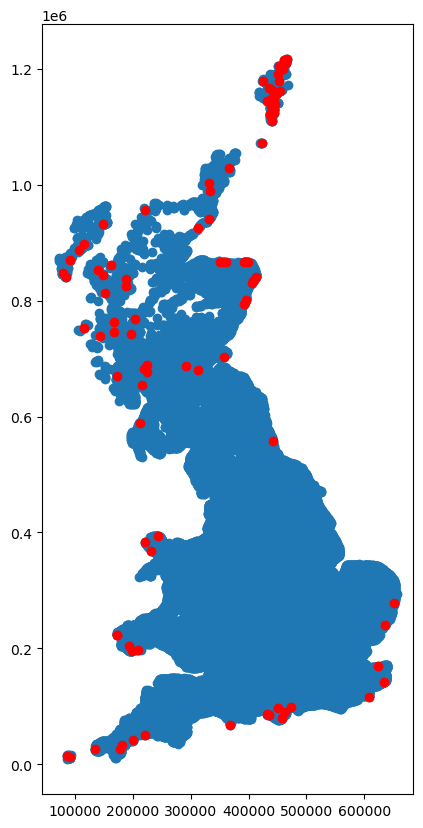

In [86]:
fig, ax = plt.subplots(figsize=(16, 10))

mapper.plot(ax=ax)
# mapper.loc[mapper.consituency.isna()].plot(ax=ax, c='r')
gpd.sjoin_nearest(mapper.loc[mapper['constituency'].isna()], ns, how='left').plot(ax=ax, c='r')

plt.show()

In [82]:
mapper.loc[mapper.consituency.isna()]

,geometry,demand,model_region,single_rate_domestic,consituency
2,POINT (466500.000 1216500.000),18.409091,6485,35.427692,NaN
5,POINT (461500.000 1214500.000),18.409091,6442,35.429843,NaN
12,POINT (464500.000 1210500.000),15.954545,6485,35.427692,NaN
20,POINT (452500.000 1205500.000),44.181818,6442,35.429843,NaN
26,POINT (456500.000 1204500.000),8.590909,6442,35.429843,NaN
...,...,...,...,...,...
125426,POINT (181500.000 32500.000),1966.090909,5207,3.023434,NaN
125632,POINT (134500.000 25500.000),42.954545,5207,3.023434,NaN
125657,POINT (178500.000 25500.000),82.227273,5207,3.023434,NaN
125794,POINT (87500.000 14500.000),67.500000,5207,3.023434,NaN
